# Dimensionality Reduction

In today's exercise you will apply some techniques for dimensionality reduction. We will dive into the popular dimensionality reduction algorithm PCA und the manifold learning algorithm t-SNE.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm
import seaborn as sns
#sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## Principal Component Analysis (PCA)
In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for **visualization**, for **noise filtering**, for **feature extraction and engineering**, and much more.
After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

### PCA Introduction
We introduce PCA by looking at a randomly generated two-dimensional dataset.

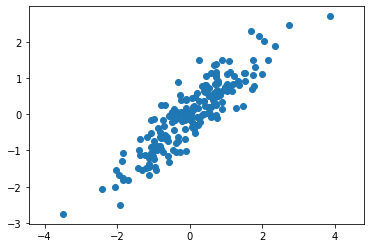

In [2]:
rng = np.random.RandomState(42)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

Let us calculate the empirical covariance of our sampled data set. We can use the formula from the lecture.

In [3]:
n_samples = X.shape[0]
covariance = np.dot(X.T, X) / (n_samples-1)
# covariance = np.cov(X, rowvar=0) # can be also done with numpy directly
covariance

array([[1.05774968, 0.85903569],
       [0.85903569, 0.87587861]])

We can see, that there is a linear relationship between the x and y variables.
Our goal here is different to regression problem: Rather than predicting the y-values from the x-values, we want to learn about the *relationship* between the x and y values. 

In PCA, this relationship is quantified by finding a list of the *principal axes* in the data and using those axes to describe the dataset.

In scikit-learn we can do that by using the [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class. We instantiate a new object from PCA and fit it to the data.

In [4]:
pca = PCA()
pca.fit(X)

PCA()

We can now access the principal components by means of the `components_` attribute. These correspond to the **eigenvectors** of the covariance matrix.

In [5]:
eigenvectors = pca.components_
eigenvectors

array([[ 0.74306799,  0.66921593],
       [-0.66921593,  0.74306799]])

Another important property is the *explained variance* which can be accessed by means of the `explained_variance_` attribute. These are the **eigenvalues** of the covariance matrix.

In [6]:
pca.explained_variance_

array([1.82927343, 0.10246373])

In [7]:
eigenvalues = np.diag(pca.explained_variance_)
eigenvalues

array([[1.82927343, 0.        ],
       [0.        , 0.10246373]])

The eigenvalue decomposition of the covariance matrix can also be calculated with numpy:

In [8]:
eigenvalues_np, eigenvectors_np = np.linalg.eig(covariance)

eigenvalues_np = np.diag(eigenvalues_np)
eigenvectors_np = eigenvectors_np.T
print("Eigenvectors:\n", eigenvectors_np)
print("\nEigenvalues:\n", eigenvalues_np)

Eigenvectors:
 [[ 0.74339408  0.66885368]
 [-0.66885368  0.74339408]]

Eigenvalues:
 [[1.83064954 0.        ]
 [0.         0.10297875]]


As numpy and scikit-learn are not using the same algorithm for the eigendecomposition, we don't get exactly the same results.

#### Visualize eigenvalues and eigenvetors
To see what these numbers mean, let's visualize them as vectors over the input data, using the **eigenvectors** to define the direction of the vector, and the **eigenvalues** to define the squared-length of the vector:

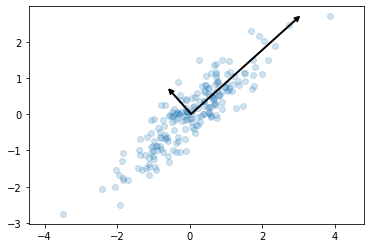

In [9]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for eigenvalue, eigenvector in zip(pca.explained_variance_, pca.components_):
    v = eigenvector * 3 * np.sqrt(eigenvalue)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

#### Reconstruct covariance matrix
Let's reconstruct our covariance matrix from the eigenvectors and eigenvalues.
$A = E^TDE$

In [10]:
covariance

array([[1.05774968, 0.85903569],
       [0.85903569, 0.87587861]])

In [11]:
covariance_reconstructed =  eigenvectors.T.dot(eigenvalues).dot(eigenvectors)
covariance_reconstructed

array([[1.05592178, 0.85869573],
       [0.85869573, 0.87581538]])

With the eigenvectors and eigenvalues calculated with the PCA-class from scikit-learn we don't get exactly the same result. 

In [12]:
covariance_reconstructed_np =  eigenvectors_np.T.dot(eigenvalues_np).dot(eigenvectors_np)
covariance_reconstructed_np

array([[1.05774968, 0.85903569],
       [0.85903569, 0.87587861]])


If we reconstruct it with the eigenvectors and eigenvalues we have calculate with numpy we get the same result.

#### Using PCA for dimensionality reduction
If we want to use PCA for dimensionality reduction, we set the eigenvectors with the smallest corresponding eigenvalues to zero, which results to a lower-dimensional projection of the data that preserves the maximal variance.

1. Compute the covariance matrix of the data
1. Compute the eigenvalues and vectors of this covariance matrix
1. Use the eigenvalues and vectors to select only the most important feature vectors and then transform your data onto those vectors for reduced dimensionality

In [13]:
n_components = 1
per_feature_mean = np.mean(X, axis=0)
X_pca = np.dot(X - per_feature_mean, eigenvectors[:n_components].T)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
print("First data point:", X_pca[0])

original shape:    (200, 2)
transformed shape: (200, 1)
First data point: [-1.74205358]


With scikit-learn, this can be done using the `transform` method of the PCA-class.

In [14]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
print("First data point:", X_pca[0])

original shape:    (200, 2)
transformed shape: (200, 1)
First data point: [-1.74205358]


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

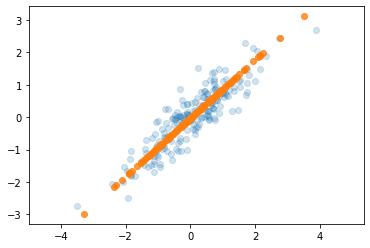

In [15]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The blue points are the original data, while the orange points are the projected version.
The information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### PCA using the Wine dataset

From our toy dataset we will move to the [wine dataset](http://archive.ics.uci.edu/ml/datasets/wine).

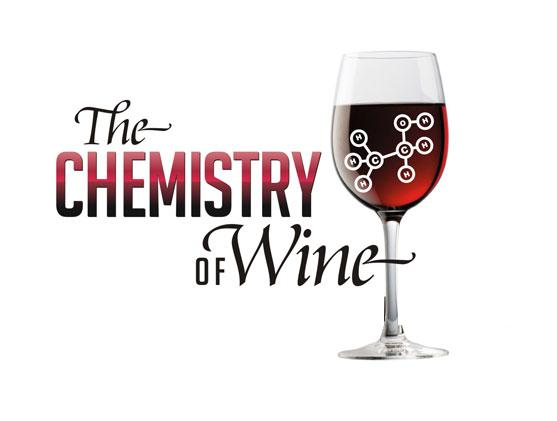 

It contains the results of a chemical analysis of wines grown in the same region in Italy but derived from 3 different cultivars. Our goal will be to reveal the presence of clusters in the wine dataset. In other words, we will check if 3 cultivators are distinguishable in the dataset.

In [16]:
df_wine = pd.read_csv("wine.csv")
df_wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


The data is already labaled by the feature **Customer Segment**. We remove the label from the data.

In [17]:
X_wine = df_wine.drop(columns=["Customer_Segment"]).values
y_wine = df_wine["Customer_Segment"].values

We apply PCA to our data and plot the explained variance.

<AxesSubplot:xlabel='# of Features'>

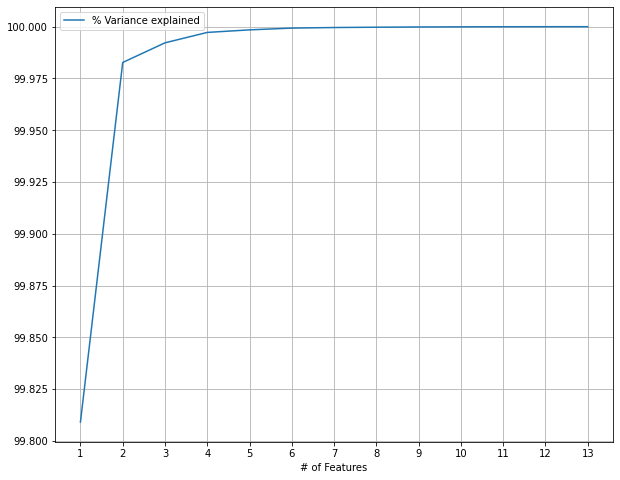

In [18]:
pca = PCA().fit(X_wine)
v_ratio = pca.explained_variance_ratio_

data = pd.DataFrame({'# of Features':range(1, len(v_ratio)+1), '% Variance explained':np.cumsum(v_ratio*100)})
data.plot(x=0, y=1, xticks=range(1, len(v_ratio)+1), grid=True, figsize=(10,8))

In this plot we can see that with 2 components we can almost retain 100% of the explained variance!

Now let us reduce the dimensionality of our dataset to two components and plot the data. We colorize the data points according to the customer segments.

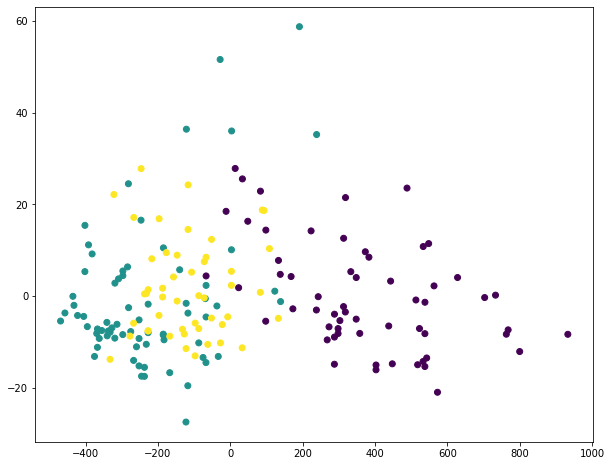

In [19]:
pca = PCA(n_components=2)
X_pca_wine = pca.fit_transform(X_wine)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca_wine[:, 0], X_pca_wine[:, 1], c=y_wine)

We can see that possibly similar points are quite widely spread.

Let's redo our dimensionality reduction, but first we scale our data. We are using a pipeline which takes as a first step our data and scales it and then reduces its dimensionality using PCA.


<AxesSubplot:xlabel='# of Features'>

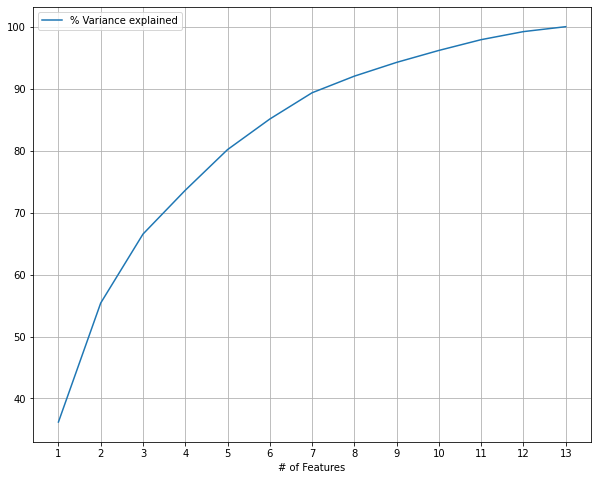

In [20]:
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("pca", PCA())
])

pipe.fit(X_wine)

v_ratio = pipe["pca"].explained_variance_ratio_
data = pd.DataFrame({'# of Features':range(1, len(v_ratio)+1), '% Variance explained':np.cumsum(v_ratio*100)})
data.plot(x=0, y=1, xticks=range(1, len(v_ratio)+1), grid=True, figsize=(10,8))

If we want to retain 90% of the variance, we would select the first 8 components. We can also use the elbow method to decide.

Let us transform our data to two components by setting the parameters of our pipeline accordingly.

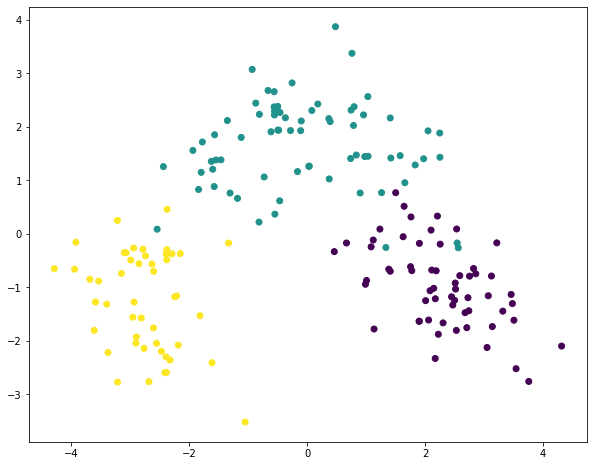

In [21]:
params = {"pca__n_components": 2}
pipe.set_params(**params)

X_pca_wine = pipe.fit_transform(X_wine)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca_wine[:, 0], X_pca_wine[:, 1], c=y_wine)

It looks much better now! Again this should give you a feeling on why scaling is so important for Machine Learning.

#### Customer segment prediction
Now we want to predict the customer segment. We extend our pipeline with a **Logistic Regression** estimator.

In [22]:
split = train_test_split(X_wine, y_wine, test_size=0.2, random_state=3)
(X_train_wine, X_test_wine, y_train_wine, y_test_wine) = split

In [23]:
model = Pipeline([
    ("scaler", StandardScaler()), 
    ("pca", PCA(n_components=0.9)),
    ("clf", LogisticRegression())
])

> Fit the model to our training data and calculate the accuracy on the test set.

In [25]:
model.fit(X_train_wine, y_train_wine)

y_pred_wine = model.predict(X_test_wine)
acc = accuracy_score(y_pred_wine, y_test_wine)
print(acc)

0.9722222222222222


In [ ]:
model.fit(X_train_wine, y_train_wine)

y_pred_wine = model.predict(X_test_wine)
accuracy_score(y_pred_wine, y_test_wine)

## t-Distributed Stochastic Neighbor Embedding (t-SNE) 
t-SNE is a [manifold learning](https://scikit-learn.org/stable/modules/manifold.html) which reduces the dimensionality while trying to keep similar instances close and dissimilar apart. It is mostly used for visualization, in particular to visualize  clusters of instances in high-dimensional space.
t-SNE constructs a probability distribution $p$ over the dataset $X$ and then another probability distribution $q$ in a lower dimensional data space $Y$, making both distributions as "close" as possible.

We now transform our data using the [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) class from scikit-learn. As t-SNE is based on nearest neighbor search, it is crucial to normalize our data first.

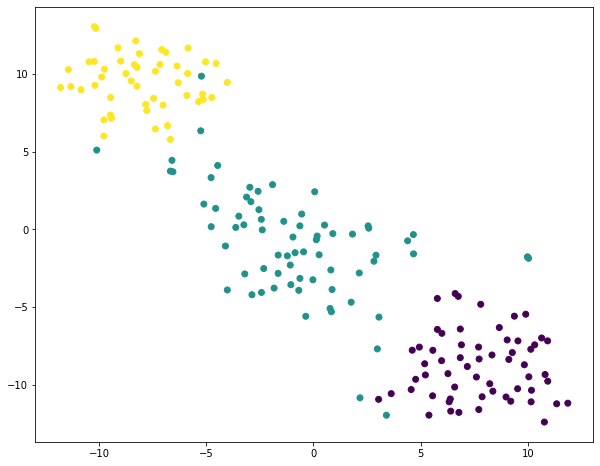

In [26]:
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("tsne", TSNE(n_components=2)),
])

X_tsne_wine = pipe.fit_transform(X_wine)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne_wine[:, 0], X_tsne_wine[:, 1], c=y_wine)

The visualization looks really nice. We can see what t-SNE tries to do: Keep similar instances clos and dissimalar apart.

Please note: As t-SNE does not support a `transform` function (it needs to be fitted to the data first) it should not be used in combination with an estimator. 

## Assignment: Using PCA with the autoscout dataset
Your assignment is now to apply the dimensionality techniques to the well known autoscout dataset.

Here is the the dataset from Autoscout24. We reuse the steps that we developed in the regression exercise to read and clean the data:

In [33]:
df = pd.read_csv("cars.csv")
df['Age'] = df.Year-1984
df.drop(['Color', 'Name', 'Registration'], axis='columns', inplace=True)
df.drop_duplicates(inplace=True)
df.drop([17010, 7734, 47002, 44369, 24720, 50574, 36542, 42611,
         22513, 12773, 21501, 2424, 52910, 29735, 43004, 47125], axis='rows', inplace=True)
df.drop(df.index[df.EngineSize > 7500], axis='rows', inplace=True)
df.head()

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,Age
0,44800,27600,2,320,4973,2,8,5,1996,12
1,22800,18300,4,286,4398,5,8,5,1999,15
2,183710,650,5,350,4172,5,8,6,2008,24
3,19900,32000,5,150,2198,7,4,6,2006,22
4,18999,118000,5,163,2401,5,5,5,2003,19


> Now reduce the dimensionality of the data using **PCA** and answer the questions on ILIAS. Don't forget to scale the data first!

In [48]:
feature_columns = ['Mileage', 'Doors', 'Year', 'Horsepower', 'Doors', 'EngineSize', 'Seats', 'Cylinders', 'Gears', 'Age']
X = df[feature_columns].values
# We convert it to float so we don't get a conversion warning when normalizing the data
X = X.astype("float") 
y = df.Price.values
X_train_car, X_test_car, y_train_car, y_test_car = X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ("scaler", StandardScaler()), 
    ("pca", PCA(n_components=10))
])



In [49]:
model.fit_transform(X_train_car, y_train_car)

array([[-3.84520089e-01, -1.35452838e+00, -9.88437562e-01, ...,
         1.55350068e-01, -1.27123881e-16,  3.32381119e-14],
       [ 2.53545974e+00, -2.56370498e+00, -2.86332252e+00, ...,
        -1.95523937e-02,  1.21987793e-13, -3.18646083e-16],
       [-7.61505641e-01, -2.35314629e+00, -7.67195837e-02, ...,
         1.44789110e-01,  5.44492580e-16,  7.26388496e-14],
       ...,
       [-5.84848485e-01,  2.99692861e-01,  5.98198088e-01, ...,
         2.91130116e-01,  6.39960491e-18,  1.14289890e-16],
       [-1.23173586e+00, -7.03661799e-01, -3.30255575e+00, ...,
         1.96094599e-01, -2.46076785e-17,  3.57074680e-17],
       [ 3.65913737e-01,  2.97295478e+00,  5.92629237e-01, ...,
        -8.39131086e-03, -2.97537691e-17,  2.28881587e-16]])

<AxesSubplot:xlabel='# of Features'>

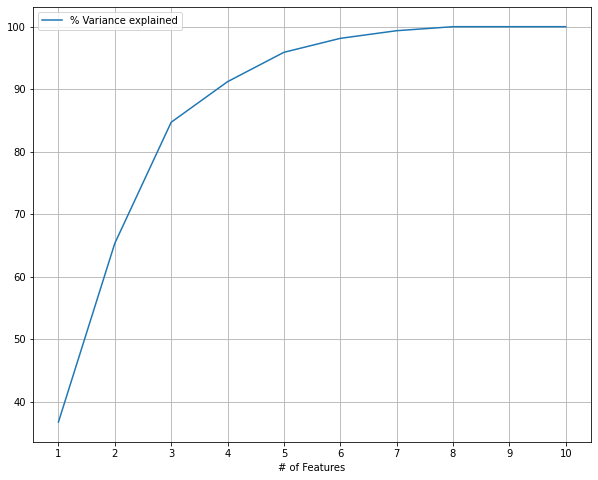

In [52]:
v_ratio = model["pca"].explained_variance_ratio_
data = pd.DataFrame({'# of Features':range(1, len(v_ratio)+1), '% Variance explained':np.cumsum(v_ratio*100)})
data.plot(x=0, y=1, xticks=range(1, len(v_ratio)+1), grid=True, figsize=(10,8))

In [36]:
y_pred_car = model.predict(X_test_car)
acc = accuracy_score(y_pred_car, y_test_car)

AttributeError: 'PCA' object has no attribute 'predict'

In [ ]:
#. pearson

stats.pearsonr([1, 2, 3, 4, 5], [10, 9, 2.5, 6, 4])